<a href="https://colab.research.google.com/github/adibayaseen/PPI-Inhibitors/blob/main/code%5CLoad_Model_GearNetEmbedding_and_GNN_based_pipeline_ipynb.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

**Set the Runtime->Change Runtime Type to GPU**

# Protein 3d structure assessment with graph neural networks

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
#!rm -r Data
!rm -r PPI-Inhibitors
!pip install biopython
!git clone https://github.com/adibayaseen/PPI-Inhibitors
#!pip install py3Dmol

rm: cannot remove 'PPI-Inhibitors': No such file or directory
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 3.1/3.1 MB 40.8 MB/s eta 0:00:00
Cloning into 'PPI-Inhibitors'...
remote: Enumerating objects: 903, done.
remote: Counting objects: 100% (98/98), done.
remote: Compressing objects: 100% (85/85), done.
remote: Total 903 (delta 26), reused 58 (delta 12), pack-reused 805
Receiving objects: 100% (903/903), 1.45 GiB | 11.92 MiB/s, done.
Resolving deltas: 100% (208/208), done.
Updating files: 100% (560/560), done.


In [ ]:
'''
Using Sklearn One hot encoder to encode the atoms
Output is of size N*M where N is the total number of atoms and M is the total number of encoded features
'''
import warnings
from Bio.PDB import *
import numpy as np
from sklearn.preprocessing import OneHotEncoder
import glob
def atom1(structure):
    atomslist=np.array(sorted(np.array(['C', 'CA', 'CB', 'CG', 'CH2', 'N','NH2',  'OG','OH', 'O1', 'O2', 'SE','1']))).reshape(-1,1)
    enc = OneHotEncoder(handle_unknown='ignore')
    enc.fit(atomslist)
    atom_list=[]
    for atom in structure.get_atoms():
        if atom.get_name() in atomslist:
            atom_list.append(atom.get_name())
        else:
            atom_list.append("1")
    atoms_onehot=enc.transform(np.array(atom_list).reshape(-1,1)).toarray()
    return atoms_onehot
##############
'''
One hot encoded residue infomration using SKlearn Library

Output is N*M where N is the total number of atoms and M is the encoded features of the residues.
Any unknown  residue is mapped to 1
'''


import warnings
import numpy as np
from sklearn.preprocessing import OneHotEncoder
import glob
from Bio.PDB import *


def res1(structure):
    residuelist=np.array(sorted(np.array(['ALA', 'ARG', 'ASN', 'ASP', 'GLN', 'GLU', 'GLY', 'ILE', 'LEU', 'LYS', 'MET', 'PHE', 'PRO', 'SER', 'THR', 'TRP', 'TYR', 'VAL', 'CYS', 'HIS','1']))).reshape(-1,1)
    encr = OneHotEncoder(handle_unknown='ignore')
    encr.fit(residuelist)



    residue_list=[]
    for atom in structure.get_atoms():
        if atom.get_parent().get_resname() in residuelist:
            residue_list.append((atom.get_parent()).get_resname())
        else:
            residue_list.append("1")

    res_onehot=encr.transform(np.array(residue_list).reshape(-1,1)).toarray()

    return res_onehot
###########

'''
It calculates the neighbours of each atom i.e. 10 distinct neighbours
Output is  in the form of a ditionary representing an  adjacency list where each source atom and neighbouring atom is represented bby its sequence index .
'''
import warnings
from Bio.PDB import *
import numpy as np
from Bio.PDB.NeighborSearch import NeighborSearch

def neigh1(structure):
    #atom_list is a numpy array  that   contains all the atoms of the pdb file in atom object
    atom_list=np.array([atom for atom in structure.get_atoms()])

    #for atom in structure.get_atoms():
    #    atom_list.append(atom)
    #neighbour_list contains all the  neighbour atomic pairs  i.e. like if N has neighbours O and C then it is stored as [[N,C],[N,O]] i.e. has dimension N*2 where N is the total number of possible neighbours all the atoms have in an unsorted manner and it stores in the form of  atom object


    p4=NeighborSearch(atom_list)
    neighbour_list=p4.search_all(6,level="A")
    neighbour_list=np.array(neighbour_list)

    #dist is the distance between the neighbour and the source atom  i.e. dimension is N*1
    dist=np.array(neighbour_list[:,0]-neighbour_list[:,1])
    #sorting in ascending order
    place=np.argsort(dist)
    sorted_neighbour_list=neighbour_list[place]

    #old_atom_number is used for  storing atom id of the original protein before sorting
    #old_residue_number is used for storing residue number of the original protein before sorting
    source_vertex_list_atom_object=np.array(sorted_neighbour_list[:,0])
    len_source_vertex=len(source_vertex_list_atom_object)
    neighbour_vertex_with_respect_each_source_atom_object=np.array(sorted_neighbour_list[:,1])
    old_atom_number=[]
    old_residue_number=[]
    for i in atom_list:
        old_atom_number.append(i.get_serial_number())
        old_residue_number.append(i.get_parent().get_id()[1])
    old_atom_number=np.array(old_atom_number)
    old_residue_number=np.array(old_residue_number)
    req_no=len(neighbour_list)
    total_atoms=len(atom_list)
    #neigh_same_res is the 2D numpy array to store the indices of the  neighbours of  same residue and is of the shape N*10 where N is the total number of atoms
    #neigh_diff_res is 2D numpy array to store  the indices of the  neighbours of different residue
    #same_flag is used to restrict the neighbours belonging to same residue  to 10
    #diff_flag is used to restrict the neighbours belonging to different residue to 10
    neigh_same_res=np.array([[-1]*10 for i in range(total_atoms)])
    neigh_diff_res=np.array([[-1]*10 for i in range(total_atoms)])
    same_flag=[0]*total_atoms
    diff_flag=[0]*total_atoms
    for i in range(len_source_vertex):
        source_atom_id=source_vertex_list_atom_object[i].get_serial_number()
        neigh_atom_id=neighbour_vertex_with_respect_each_source_atom_object[i].get_serial_number()
        source_atom_res=source_vertex_list_atom_object[i].get_parent().get_id()[1]
        neigh_atom_res=neighbour_vertex_with_respect_each_source_atom_object[i].get_parent().get_id()[1]
        #finding out index of the source and neighbouring atoms from the original atom array with respect to their residue id and atom id
        temp_index1=np.where(source_atom_id==old_atom_number)[0]

        temp_index2=np.where(neigh_atom_id==old_atom_number)[0]
        for i1 in temp_index1:
            if old_residue_number[i1]==source_atom_res:
                source_index=i1
                break
        for i1 in temp_index2:
            if old_residue_number[i1]==neigh_atom_res:
                neigh_index=i1
                break
        #if both the residues are same

        if source_atom_res==neigh_atom_res :

            #limiting the number of neighbours of same residue to 10

            if int(same_flag[source_index])< 10:
                neigh_same_res[source_index][same_flag[source_index]]=neigh_index
                same_flag[source_index]+=1

            if int(same_flag[neigh_index])< 10:
                neigh_same_res[neigh_index][same_flag[neigh_index]]=source_index
                same_flag[neigh_index]+=1

        # if both the residues are different
        elif source_atom_res!=neigh_atom_res :

            #limiting the number of neighbours of different residues to 10

            if int(diff_flag[source_index])< 10:
                neigh_diff_res[source_index][diff_flag[source_index]]=neigh_index
                diff_flag[source_index]+=1


            if int(diff_flag[neigh_index])< 10:

                neigh_diff_res[neigh_index][diff_flag[neigh_index]]=source_index
                diff_flag[neigh_index]+=1




    return neigh_same_res,neigh_diff_res
import torch.optim as optim
import torch.nn as nn
#os.environ['CUDA_LAUNCH_BLOCKING'] = "1"
#from QA.data_import import get_dataloader,data1
#from QA.temp_network import GNN
import torch
import matplotlib.pyplot as plt
import torch.nn.functional as F
import pdb
class GNN_Layer(nn.Module):

    def __init__(self, filters, v_feats, trainable=True, **kwargs):
        #pdb.set_trace()
        super(GNN_Layer, self).__init__()
        self.v_feats = v_feats
        self.filters = filters

        self.trainable = trainable
        use_cuda = torch.cuda.is_available()
        device = torch.device("cuda:0" if use_cuda else "cpu")
        self.cuda_device=device
        self.Wsv = nn.Parameter( torch.randn(self.v_feats, self.filters, device=self.cuda_device,requires_grad=True))
        self.Wdr = nn.Parameter( torch.randn(self.v_feats, self.filters, device=self.cuda_device,requires_grad=True))
        self.Wsr = nn.Parameter( torch.randn(self.v_feats, self.filters, device=self.cuda_device,requires_grad=True))
        self.neighbours=10
        #print("Wsv shape",self.Wsv.shape)

    def forward(self, x):
        #pdb.set_trace()
        Z,same_neigh,diff_neigh = x
        #print("input",x)
        #print(Z.shape)
        node_signals = Z@self.Wsv
        neigh_signals_same=Z@self.Wsr
        neigh_signals_diff=Z@self.Wdr
        unsqueezed_same_neigh_indicator=(same_neigh>-1).unsqueeze(2)
        unsqueezed_diff_neigh_indicator=(diff_neigh>-1).unsqueeze(2)
        same_neigh_features=neigh_signals_same[same_neigh]*unsqueezed_same_neigh_indicator
        diff_neigh_features=neigh_signals_diff[diff_neigh]*unsqueezed_diff_neigh_indicator
        same_norm = torch.sum(same_neigh > -1, 1).unsqueeze(1).type(torch.float)
        diff_norm = torch.sum(diff_neigh > -1, 1).unsqueeze(1).type(torch.float)

        # To prevent divide by zero error
        same_norm[same_norm==0]=1
        diff_norm[diff_norm==0]=1
        neigh_same_atoms_signal = (torch.sum(same_neigh_features, axis=1))/same_norm
        neigh_diff_atoms_signal = (torch.sum(diff_neigh_features, axis=1))/diff_norm
        final_res = torch.relu(node_signals +neigh_same_atoms_signal+neigh_diff_atoms_signal)

        return final_res,same_neigh,diff_neigh

class GNN_First_Layer(nn.Module):

    def __init__(self, filters, trainable=True, **kwargs):

        super(GNN_First_Layer, self).__init__()
        self.filters = filters
        #pdb.set_trace()
        self.trainable = trainable
        use_cuda = torch.cuda.is_available()
        device = torch.device("cuda:0" if use_cuda else "cpu")
        self.cuda_device = device
        self.Wv = nn.Parameter( torch.randn(13, self.filters, device=self.cuda_device,requires_grad=True))
        self.Wr = nn.Parameter( torch.randn(21,self.filters, device=self.cuda_device,requires_grad=True))
        self.Wsr= nn.Parameter( torch.randn(13, self.filters, device=self.cuda_device,requires_grad=True))
        self.Wdr= nn.Parameter( torch.randn(13, self.filters, device=self.cuda_device,requires_grad=True))
        self.neighbours=10


    def forward(self, x):
        atoms, residues,same_neigh,diff_neigh = x
        node_signals = atoms@self.Wv
        residue_signals = residues@self.Wr
        neigh_signals_same=atoms@self.Wsr
        neigh_signals_diff=atoms@self.Wdr
        unsqueezed_same_neigh_indicator=(same_neigh>-1).unsqueeze(2)
        unsqueezed_diff_neigh_indicator=(diff_neigh>-1).unsqueeze(2)
        """
        unsqueezed_same_neigh_indicator=(same_neigh>-1).unsqueeze(1)
        unsqueezed_diff_neigh_indicator=(diff_neigh>-1).unsqueeze(1)
        """
        same_neigh_features=neigh_signals_same[same_neigh]*unsqueezed_same_neigh_indicator
        diff_neigh_features=neigh_signals_diff[diff_neigh]*unsqueezed_diff_neigh_indicator
        same_norm = torch.sum(same_neigh > -1, 1).unsqueeze(1).type(torch.float)
        diff_norm = torch.sum(diff_neigh > -1, 1).unsqueeze(1).type(torch.float)
        same_norm = torch.sum(same_neigh > -1).type(torch.float)
        diff_norm = torch.sum(diff_neigh > -1).type(torch.float)
        # To prevent divide by zero error
        same_norm[same_norm==0]=1
        diff_norm[diff_norm==0]=1
        neigh_same_atoms_signal=(torch.sum(same_neigh_features, axis=1))/same_norm
        neigh_diff_atoms_signal=(torch.sum(diff_neigh_features, axis=1))/diff_norm

        final_res = torch.relu(node_signals+residue_signals +neigh_same_atoms_signal+neigh_diff_atoms_signal)
        #pdb.set_trace()
        #print(" in First layer final_res.shape",final_res.shape,"same_neigh.shape",same_neigh.shape,"diff_neigh.shape",diff_neigh.shape)
        return final_res, same_neigh,diff_neigh
class Dense(nn.Module):
    def __init__(self, in_dims, out_dims, trainable=True, **kwargs):
        #pdb.set_trace()
        super(Dense, self).__init__()
        self.in_dims = in_dims
        self.out_dims = out_dims
        use_cuda = torch.cuda.is_available()
        device = torch.device("cuda:0" if use_cuda else "cpu")
        self.cuda_device = device

        self.W = nn.Parameter( torch.randn(self.in_dims, self.out_dims, device=self.cuda_device,requires_grad=True))

    def forward(self, x):
        #pdb.set_trace()
        Z = torch.sigmoid(torch.matmul(x, self.W))

        return Z

class GNN(torch.nn.Module):
    def __init__(self):
        super(GNN, self).__init__()
        #pdb.set_trace()
        #Actual
        """
        self.conv1 = GNN_First_Layer(filters=128)
        self.conv2 = GNN_Layer(v_feats=128, filters=256)
        self.conv3 = GNN_Layer(v_feats=256, filters=512)
        self.dense = Dense(in_dims=512, out_dims=1)
        """
        #modified by me
        self.conv1 = GNN_First_Layer(filters=512)
        self.conv2 = GNN_Layer(v_feats=512, filters=1024)
        self.conv3 = GNN_Layer(v_feats=1024, filters=512)
        self.dense = Dense(in_dims=512, out_dims=1)
    def forward(self, x):
        #pdb.set_trace()
        x1=self.conv1(x)
        #pdb.set_trace()
        x2=self.conv2(x1)
        #pdb.set_trace()
        x3=self.conv3(x2)
        #pdb.set_trace()
        x=x3[0]
        x=torch.sum(x,axis=0).view(1,-1)
        #pdb.set_trace()
        x = F.normalize(x)
        """
        #pdb.set_trace()
        x5=self.dense(x)
        #pdb.set_trace()
        x6=torch.squeeze(x5,1)
        """
        #print("GNN")

        return x#x6,

    def processProtein(UniqueProtein, PdBloc):#, PdBloc):
        data_list = []
        #PdBloc='/content/PPI-Inhibitors/Data/Pdb/'
        #data=glob.glob(PdBloc+'/*')
        #data=glob.glob(PdBloc)
        #data=data[0:2]
        #assert (len(UniqueProtein) == len(data)) , "The two lists must be the same length!"
        use_cuda = torch.cuda.is_available()
        device = torch.device("cuda:0" if use_cuda else "cpu")
        PData_dict={}
        for i in range(len(UniqueProtein)):
            #print('Converting PDB to Graph: {}/{}'.format(i+1, len(UniqueProtein)))
            UniqueProtein[i]=UniqueProtein[i].split('.pdb')[0]
            P1=PdBloc+UniqueProtein[i]+'.pdb'
            #if P1 in UniqueProtein:
            parser = PDBParser()
            with warnings.catch_warnings(record=True) as w:
              structure = parser.get_structure("", P1)
            one_hot_atom=(atom1(structure))
            #print("\none_hot_atom.shape",one_hot_atom.shape)
            #
            one_hot_res=(res1(structure))
            #print("\none_hot_atom.shape",one_hot_res.shape)
            neigh_same_res,neigh_diff_res=(neigh1(structure))
            #print("\neigh_same_res.shape,neigh_diff_re.shape",neigh_same_res.shape,"\n",neigh_diff_res.shape)
            # make the graph ready for PyTorch Geometrics GCN algorithms:
            one_hot_atom=torch.tensor(one_hot_atom,dtype=torch.float32).to(device)
            one_hot_res=torch.tensor(one_hot_res,dtype=torch.float32).to(device)
            neigh_same_res=torch.tensor(neigh_same_res).to(device).long()
            neigh_diff_res=torch.tensor(neigh_diff_res).to(device).long()
            GNNData = [one_hot_atom,one_hot_res,neigh_same_res,neigh_diff_res]
            #import pdb; pdb.set_trace()
            #GNNData.__setitem__('Total atoms', len(one_hot_atom))
            #data_list.append(GNNData)
            PData_dict[UniqueProtein[i]]= GNNData
        return PData_dict
def readFile(filename):
  with open(filename) as f:
    D = f.readlines()
  Name=[];PdbId=[];Ligandnames=[];SMILES=[];labels=[];
  All_data_list=[]
  from tqdm import tqdm as tqdm
  #2XA0_A_2_B 2O21 2XA0 43B c1ccc(cc1)CCc2nc3cc(ccc3s2)c4ccc(cc4)C(=O)NS(=O)(=O)c5ccc(c(c5)[N](=O)[O-])NCCSc6ccccc6  1
  for d in tqdm(D):
      #if len(d)==6:
      name,inhibtedc,Pdbid,Ligandid,smiles,y = d.split()
      Name.append(name);PdbId.append(Pdbid);Ligandnames.append(Ligandid);SMILES.append(smiles);labels.append(float (y));
  return  PdbId,Ligandnames,SMILES,labels



In [ ]:
# Add this in a Google Colab cell to install the correct version of Pytorch Geometric.
import torch

def format_pytorch_version(version):
  return version.split('+')[0]

TORCH_version = torch.__version__
TORCH = format_pytorch_version(TORCH_version)

def format_cuda_version(version):
  return 'cu' + version.replace('.', '')

CUDA_version = torch.version.cuda
CUDA = format_cuda_version(CUDA_version)
"""
!pip install torch-scatter -f https://data.pyg.org/whl/torch-{TORCH}+{CUDA}.html
!pip install torch-sparse -f https://data.pyg.org/whl/torch-{TORCH}+{CUDA}.html
!pip install torch-cluster -f https://data.pyg.org/whl/torch-{TORCH}+{CUDA}.html
!pip install torch-spline-conv -f https://data.pyg.org/whl/torch-{TORCH}+{CUDA}.html
!pip install torch-geometric
"""

'\n!pip install torch-scatter -f https://data.pyg.org/whl/torch-{TORCH}+{CUDA}.html\n!pip install torch-sparse -f https://data.pyg.org/whl/torch-{TORCH}+{CUDA}.html\n!pip install torch-cluster -f https://data.pyg.org/whl/torch-{TORCH}+{CUDA}.html\n!pip install torch-spline-conv -f https://data.pyg.org/whl/torch-{TORCH}+{CUDA}.html\n!pip install torch-geometric\n'

In [ ]:
#Compound part
!pip install kora
import kora.install.rdkit

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 57.7/57.7 kB 2.1 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.6/1.6 MB 47.4 MB/s eta 0:00:00


In [ ]:
#from torch_geometric.data import InMemoryDataset, DataLoader

In [ ]:
!pip install rdkit

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 30.5/30.5 MB 44.0 MB/s eta 0:00:00


In [ ]:
from rdkit import Chem

In [ ]:
#from torch_geometric.nn.conv import gcn_conv
##
import glob
import pandas as pd
import numpy as np
import os
import json,pickle
from collections import OrderedDict
from rdkit import Chem
#from rdkit.Chem import MolFromSmiles
import networkx as nx
#from utils import *
# training function at each epoch
def train(model, device, train_loader, optimizer, epoch):
    print('Training on {} samples...'.format(len(GCN_data)))

    model.train()
    loss_fn = nn.MSELoss()
    for batch_idx, data in enumerate(train_loader):
        #data = data.to(device)
        optimizer.zero_grad()
        output,Sfeatures= model(data)#,Sfeatures
        loss = loss_fn(output, data.target.view(-1, 1).float().to(device))
        #loss = loss_fn(output, data.Target.view(-1, 1).float().to(device))
        loss.backward()
        optimizer.step()
        if batch_idx % LOG_INTERVAL == 0:
            print('Train epoch: {} [{}/{} ({:.0f}%)]\tLoss: {:.6f}'.format(epoch,
                                                                           batch_idx * len(data.x),
                                                                           len(train_loader.dataset),
                                                                           100. * batch_idx / len(train_loader),
                                                                           loss.item()))

def predicting(model, device,test_loader,labels):
    model.eval()
    total_preds = torch.Tensor()
    total_labels = torch.Tensor()
    print('Make prediction for {} samples...'.format(len(test_loader)))
    with torch.no_grad():
        for batch_idx, data in enumerate(test_loader):
            #data = data.to(device)
            try:
              output,Sfeatures = model(data)#,Sfeatures
            except Exception as trr:
              print (trr)
              continue
            #output = model(data)
            #print ("output",output)
            #pdb.set_trace()
            total_preds = torch.cat((total_preds, output.cpu()), 0)
            total_labels = torch.cat((total_labels, data.target.view(-1, 1).cpu()), 0)
    return total_labels.numpy().flatten(),total_preds.numpy().flatten(),Sfeatures
##
def atom_features(atom):
    return np.array(one_of_k_encoding_unk(atom.GetSymbol(),['C', 'N', 'O', 'S', 'F', 'Si', 'P', 'Cl', 'Br', 'Mg', 'Na','Ca', 'Fe', 'As', 'Al', 'I', 'B', 'V', 'K', 'Tl', 'Yb','Sb', 'Sn', 'Ag', 'Pd', 'Co', 'Se', 'Ti', 'Zn', 'H','Li', 'Ge', 'Cu', 'Au', 'Ni', 'Cd', 'In', 'Mn', 'Zr','Cr', 'Pt', 'Hg', 'Pb', 'Unknown']) +
                    one_of_k_encoding(atom.GetDegree(), [0, 1, 2, 3, 4, 5, 6,7,8,9,10]) +
                    one_of_k_encoding_unk(atom.GetTotalNumHs(), [0, 1, 2, 3, 4, 5, 6,7,8,9,10]) +
                    one_of_k_encoding_unk(atom.GetImplicitValence(), [0, 1, 2, 3, 4, 5, 6,7,8,9,10]) +
                    [atom.GetIsAromatic()])

def one_of_k_encoding(x, allowable_set):
    if x not in allowable_set:
        raise Exception("input {0} not in allowable set{1}:".format(x, allowable_set))
    return list(map(lambda s: x == s, allowable_set))

def one_of_k_encoding_unk(x, allowable_set):
    """Maps inputs not in the allowable set to the last element."""
    if x not in allowable_set:
        x = allowable_set[-1]
    return list(map(lambda s: x == s, allowable_set))

def smile_to_graph(smile):
    mol = Chem.MolFromSmiles(smile)
    if mol is not None:
      c_size = mol.GetNumAtoms()
      features = []
      for atom in mol.GetAtoms() :
          feature = atom_features(atom)
          features.append( feature / sum(feature) )

      edges = []
      for bond in mol.GetBonds():
          edges.append([bond.GetBeginAtomIdx(), bond.GetEndAtomIdx()])
      g = nx.Graph(edges).to_directed()
      edge_index = []
      for e1, e2 in g.edges:
          edge_index.append([e1, e2])

      return c_size, features, edge_index
import os
import numpy as np
from math import sqrt
from scipy import stats
#from torch_geometric.data import InMemoryDataset, DataLoader
#from torch_geometric import data as DATA
import torch
from sklearn.metrics import roc_auc_score,roc_curve,precision_score,recall_score,average_precision_score
class PrepairDataset():
    """
    def __init__(self, root='/content/PPI-Inhibitors/Data/2p2iInhibitorsSMILES.txt', dataset='PPI-Inhibitor',
                 xd=None, xt=None, y=None, transform=None,
                 pre_transform=None,smile_graph=None,PdBloc='/content/PPI-Inhibitors/Data/Pdb/*'):

        #root is required for save preprocessed data, default is '/tmp'
        super(PrepairDataset, self).__init__(root, transform, pre_transform)
        # benchmark dataset, default = 'davis'
        self.dataset = dataset
        if os.path.isfile(self.processed_paths[0]):
            print('Pre-processed data found: {}, loading ...'.format(self.processed_paths[0]))
            self.data, self.slices = torch.load(self.processed_paths[0])
        else:
            print('Pre-processed data {} not found, doing pre-processing...'.format(self.processed_paths[0]))
            with open(root) as f:
              D = f.readlines()
            Name=[];PdbId=[];LigandId=[];SMILES=[];labels=[];
            from tqdm import tqdm as tqdm
            #2XA0_A_2_B 2O21 2XA0 43B c1ccc(cc1)CCc2nc3cc(ccc3s2)c4ccc(cc4)C(=O)NS(=O)(=O)c5ccc(c(c5)[N](=O)[O-])NCCSc6ccccc6  1
            for d in tqdm(D):
                name,inhibtedc,Pdbid,Ligandid,smiles,y = d.split()
                Name.append(name);PdbId.append(Pdbid);LigandId.append(Ligandid);SMILES.append(smiles);labels.append(y);
            PdBloc='/content/PPI-Inhibitors/Data/Pdb'
            self.process(SMILES, PdbId, labels,smile_graph,PdBloc)
            self.data, self.slices = torch.load(self.processed_paths[0])
    """
    def ProcessfromFile(self,filename,smile_graph):
        PdBloc='/content/PPI-Inhibitors/Data/Pdb'
        with open(filename) as f:
          D = f.readlines()
        Name=[];PdbId=[];LigandId=[];SMILES=[];labels=[];
        All_data_list=[]
        from tqdm import tqdm as tqdm
        #2XA0_A_2_B 2O21 2XA0 43B c1ccc(cc1)CCc2nc3cc(ccc3s2)c4ccc(cc4)C(=O)NS(=O)(=O)c5ccc(c(c5)[N](=O)[O-])NCCSc6ccccc6  1
        for d in tqdm(D):
            if len(d)==6:
              name,inhibtedc,Pdbid,Ligandid,smiles,y = d.split()
              Name.append(name);PdbId.append(Pdbid);LigandId.append(Ligandid);SMILES.append(smiles);labels.append(y);
            elif len(d)==2:
              Pdbid,smiles= d.split()
              PdbId.append(Pdbid);SMILES.append(smiles);labels.append(float(-1.0));
         ########
        UniqueProtein=list (set (PdbId))
        UniqueSMILES=list (set (SMILES))
        ProteinData_dict=PrepairDataset.processProtein(UniqueProtein,PdBloc)
        SmilesData_dict=PrepairDataset.processSMILES(UniqueSMILES, labels_list,smile_graph)
        for e in range(len(SMILES)):
          Pdata,Sdata,label=PdbId[e],SMILES[e],labels[e]
          #Preprocessed data
          if Sdata in SmilesData_dict and Pdata in ProteinData_dict:
            Pdata,Sdata=ProteinData_dict[Pdata],SmilesData_dict[Sdata]
            All_data=DATA.data(Pdata,Sdata,label)
            All_data_list.append(All_data)
        return All_data_list
    # Customize the process method to fit the task of drug-target affinity prediction
    # Inputs:
    # XD - list of SMILES
    #XT: target Protein PDB id
    # Y: list of labels (i.e. affinity)
    # Return: PyTorch-Geometric format processed data
    def process(xd, xt, y,smile_graph):
        assert (len(xd) == len(xt) and len(xt) == len(y)), "The three lists must be the same length!"
        data_list = []
        data_len = len(xd)
        print("data len",data_len)
        smiles_list=[];targetP_list=[];labels_list=[];
        for i in range(data_len):
            #print('Converting SMILES to graph: {}/{}'.format(i+1, data_len))
            smiles = xd[i]
            targetP = xt[i]
            labels = y[i]
            smiles_list.append(smiles);targetP_list.append(targetP);labels_list.append(labels);
        ########
        UniqueProtein=list (set (targetP_list))
        UniqueSMILES=list (set (smiles_list))
        ProteinData_dict=PrepairDataset.processProtein(UniqueProtein[0:2])#,PdBloc)
        print( "total pdbs",len(ProteinData_dict))
        SmilesData_dict=PrepairDataset.processSMILES(UniqueSMILES, labels_list,smile_graph)
        All_data_list=[]
        """
        with open(filename) as f:
          D = f.readlines()
        Name=[];PdbId=[];LigandId=[];SMILES=[];labels=[];
        All_data_list=[]
        from tqdm import tqdm as tqdm
        #2XA0_A_2_B 2O21 2XA0 43B c1ccc(cc1)CCc2nc3cc(ccc3s2)c4ccc(cc4)C(=O)NS(=O)(=O)c5ccc(c(c5)[N](=O)[O-])NCCSc6ccccc6  1
        for d in tqdm(D):
            if len(d)==6:
              name,inhibtedc,Pdbid,Ligandid,smiles,y = d.split()
              Name.append(name);PdbId.append(Pdbid);LigandId.append(Ligandid);SMILES.append(smiles);labels.append(y);
              #Preprocessed data
              Pdata,Sdata,label=ProteinData_dict[Pdbid],SmilesData_dict[smiles],y
              All_data=DATA.data(Pdata,Sdata,label)
              All_data_list.append(All_data)
            elif len(d)==2:
              Pdbid,smiles= d.split()
              PdbId.append(Pdbid);SMILES.append(smiles);labels.append(float(-1.0));
              #Preprocessed data
              Pdata,Sdata,label=ProteinData_dict[Pdbid],SmilesData_dict[smiles],float(-1.0)
              All_data=DATA.data(Pdata,Sdata,label)
              All_data_list.append(All_data)
        return All_data_list
        """
        for e in range(len(smiles_list)):
          Pdata,Sdata,label=targetP_list[e],smiles_list[e],labels_list[e]
          #Preprocessed data
          if Sdata in SmilesData_dict and Pdata in ProteinData_dict:
            print("Sdata,Pdata,label",Sdata,Pdata,label)
            GNN_data,GCN_data=ProteinData_dict[Pdata],SmilesData_dict[Sdata]
            All_data=(GNN_data,GCN_data,label)
            All_data_list.append(All_data)
        return All_data_list
    def processProtein(UniqueProtein, PdBloc):#, PdBloc):
        data_list = []
        #PdBloc='/content/PPI-Inhibitors/Data/Pdb/'
        #data=glob.glob(PdBloc+'/*')
        #data=glob.glob(PdBloc)
        #data=data[0:2]
        #assert (len(UniqueProtein) == len(data)) , "The two lists must be the same length!"
        use_cuda = torch.cuda.is_available()
        device = torch.device("cuda:0" if use_cuda else "cpu")
        PData_dict={}
        for i in range(len(UniqueProtein)):
            #print('Converting PDB to Graph: {}/{}'.format(i+1, len(UniqueProtein)))
            UniqueProtein[i]=UniqueProtein[i].split('.pdb')[0]
            P1=PdBloc+UniqueProtein[i]+'.pdb'
            #if P1 in UniqueProtein:
            parser = PDBParser()
            with warnings.catch_warnings(record=True) as w:
              structure = parser.get_structure("", P1)
            one_hot_atom=(atom1(structure))
            #print("\none_hot_atom.shape",one_hot_atom.shape)
            #
            one_hot_res=(res1(structure))
            #print("\none_hot_atom.shape",one_hot_res.shape)
            neigh_same_res,neigh_diff_res=(neigh1(structure))
            #print("\neigh_same_res.shape,neigh_diff_re.shape",neigh_same_res.shape,"\n",neigh_diff_res.shape)
            # make the graph ready for PyTorch Geometrics GCN algorithms:
            one_hot_atom=torch.tensor(one_hot_atom,dtype=torch.float32).to(device)
            one_hot_res=torch.tensor(one_hot_res,dtype=torch.float32).to(device)
            neigh_same_res=torch.tensor(neigh_same_res).to(device).long()
            neigh_diff_res=torch.tensor(neigh_diff_res).to(device).long()
            GNNData = [one_hot_atom,one_hot_res,neigh_same_res,neigh_diff_res]
            #import pdb; pdb.set_trace()
            #GNNData.__setitem__('Total atoms', len(one_hot_atom))
            #data_list.append(GNNData)
            PData_dict[UniqueProtein[i]]= GNNData
        return PData_dict
    def processSMILES(xd, targets,smile_graph):
        #assert (len(xd) == len(smile_graph)), "The two lists must be the same length!"
        data_list = []
        data_len = len(xd)
        Sdata_dict={}
        for i in range(data_len):
            print('Converting SMILES to graph: {}/{}'.format(i+1, data_len))
            smiles = xd[i]
            target=targets[i]
            print("target",target)
            mol = Chem.MolFromSmiles(smile)
            if smile in smile_graph and mol is not None and smile_graph[smiles] is not None:
              #import pdb; pdb.set_trace()
              # convert SMILES to molecular representation using rdkit
              c_size, features, edge_index = smile_graph[smiles]
              if c_size>1:
                # make the graph ready for PyTorch Geometrics GCN algorithms:
                GCNData = DATA.Data(x=torch.Tensor(features),
                                    edge_index=torch.LongTensor(edge_index).transpose(1, 0),target=torch.LongTensor([target]))
                #import pdb; pdb.set_trace()
              # GCNData.target = torch.LongTensor([target])
                #GCNData.__setitem__('c_size', torch.LongTensor([c_size]))
                # append graph, label and target sequence to data list
                #data_list.append(GCNData)
                Sdata_dict[smiles]=GCNData
        #Sdata_dict=dict(zip(xd,data_list))
        return Sdata_dict
        if self.pre_filter is not None:
            data_list = [data for data in data_list if self.pre_filter(data)]

        if self.pre_transform is not None:
            data_list = [self.pre_transform(data) for data in data_list]
        print('Graph construction done. Saving to file.')
        data, slices = self.collate(data_list)
        # save preprocessed data:
        torch.save((data, slices), self.processed_paths[0])


In [ ]:
from rdkit import Chem
from rdkit.Chem import AllChem
from rdkit.Chem import DataStructs
def getFP(s,r = 3,nBits =2048):
    compound = Chem.MolFromSmiles(s.strip())
    if compound is not None:
        fp = AllChem.GetMorganFingerprintAsBitVect(compound, r, nBits = nBits)
        #fp = pat.GetAvalonCountFP(compound,nBits=nBits)
        m = np.zeros((0, ), dtype=np.int8)
        DataStructs.ConvertToNumpyArray(fp, m)
        return m
def twomerFromSeq(s):
    k=2
    groups={'A':'1','V':'1','G':'1','I':'2','L':'2','F':'2','P':'2','Y':'3',
            'M':'3','T':'3','S':'3','H':'4','N':'4','Q':'4','W':'4',
            'R':'5','K':'5','D':'6','E':'6','C':'7'}
    crossproduct=[''.join (i) for i in product("1234567",repeat=k)]
    for i in range (0,len(crossproduct)): crossproduct[i]=int(crossproduct[i])
    ind=[]
    for i in range (0,len(crossproduct)): ind.append(i)
    combinations=dict(zip(crossproduct,ind))

    V=np.zeros(int((math.pow(7,k))))      #defines a vector of 343 length with zero entries
    try:
        for j in range (0,len(s)-k+1):
            kmer=s[j:j+k]
            c=''
            for l in range(0,k):
                c+=groups[kmer[l]]
                V[combinations[int(c)]]+=1
    except:
        count={'1':0,'2':0,'3':0,'4':0,'5':0,'6':0,'7':0}
        for q in range(0,len(s)):
            if s[q]=='A' or s[q]=='V' or s[q]=='G':
                count['1']+=1
            if s[q]=='I' or s[q]=='L'or s[q]=='F' or s[q]=='P':
                count['2']+=1
            if s[q]=='Y' or s[q]=='M'or s[q]=='T' or s[q]=='S':
                count['3']+=1
            if s[q]=='H' or s[q]=='N'or s[q]=='Q' or s[q]=='W':
                count['4']+=1
            if s[q]=='R' or s[q]=='K':
                count['5']+=1
            if s[q]=='D' or s[q]=='E':
                count['6']+=1
            if s[q]=='C':
                count['7']+=1
        val=list(count.values()  )           #[ 0,0,0,0,0,0,0]
        key=list(count.keys()     )           #['1', '2', '3', '4', '5', '6', '7']
        m=0
        ind=0
        for t in range(0,len(val)):     #find maximum value from val
            if m<val[t]:
                m=val[t]
                ind=t
        m=key [ind]                     # m=group number of maximum occuring group alphabets in protein
        for j in range (0,len(s)-k+1):
            kmer=s[j:j+k]
            c=''
            for l in range(0,k):
                if kmer[l] not in groups:
                    c+=m
                else:
                    c+=groups[kmer[l]]
            V[combinations[int(c)]]+=1

    V=V/(len(s)-1)
    return np.array(V)
from scipy import spatial
def chainLabel(Cname_T,xl_T,Cname,xl):
    """
    Cname_T: Target chain Name
    xl_T: Target chain co-ordinates
    Cname: Off Target chain Name
    xl: Off Target chain co-ordinates
    """
    tc = getCoords(xl_T)
    nc = getCoords(xl)
    D = getDist(tc, nc, thr = 8.0)
    feats=extract_feats(generate_pair_features(D,xl_T,xl))
    return feats
def generate_pair_features(dist_info,xl,xr):
    prot_dic=make_dic()
#    pdb.set_trace()
    for rec in dist_info:

        try:
            l_letter= three_to_one(xl[rec[0]].get_resname())
            r_letter= three_to_one(xr[rec[1]].get_resname())
#            print(l_letter,l_letter)
            if (l_letter,r_letter) in prot_dic.keys():
                prot_dic[(l_letter,r_letter)]+=1
            elif (r_letter,l_letter) in prot_dic.keys():
                prot_dic[(r_letter,l_letter)]+=1
        except:
            prot_dic[('_','_')]+=1
    return prot_dic
def getCoords(R):
    """
    Get atom coordinates given a list of biopython residues
    """
    Coords = []
    for (idx, r) in enumerate(R):
        v = [ak.get_coord() for ak in r.get_list()]
        Coords.append(v)
    return Coords
def InterfaceFeatures(Complexs,pdbloc):
    Found =  listdir(pdbloc)
    InterfaceFeatures=[];InterfaceFeatures=dict(InterfaceFeatures)
    comp_id=list(set(Complexs))
    for ids in range(len(comp_id)):
        if comp_id[ids]+'.pdb' in Found:
            stx=pdbloc+'/'+comp_id[ids]+'.pdb'#'/2XA0.pdb'
            chains=Struct2chain(stx)
            for j in range(len(chains)):
                Cname_T,seq_T,L_T,xl_T=chains[j]
                for k in range(j,len(chains)):
                    Cname,seq,L,xl=chains[k]
                    #if Cname_T!=Cname and Cname!=' 'and Cname_T!=' ':
                    name=comp_id[ids]#+'_'+Cname_T+'_2_'+Cname
                    Interface=chainLabel(Cname_T,xl_T,Cname,xl)
                    InterfaceF=np.array(Interface)
                    InterfaceF=normalize(np.atleast_2d(InterfaceF), norm='l2', copy=True, axis=1, return_norm=False)
                    if name not in InterfaceFeatures.keys():
                        InterfaceFeatures[name]=Interface
    #pickle.dump(InterfaceFeatures, open(path+Filename+"_InterfaceFeatures.npy", "wb"))
    return InterfaceFeatures
def getDist(C0, C1, thr=np.inf):
    """

    """
    N0 = []
    N1 = []
    for i in range(len(C0)):
        for j in range(len(C1)):
            d = spatial.distance.cdist(C0[i], C1[j]).min()
            # dji=spatial.distance.cdist(C1[j], C0[i]).min()
            #d=min(dij,dji)
            #print d
            if (d < thr):  # and not np.isnan(self.Phi[i]) and not np.isnan(self.Phi[j])
                N0.append((i, j, d))
                N1.append((j, i, d))
    return (N0, N1)
from Bio import SeqIO
from Bio.SeqIO import FastaIO
from itertools import product
from Bio.SeqUtils.ProtParam import ProteinAnalysis
from sklearn.preprocessing import normalize
import math
import numpy as np
from Bio.Data import IUPACData
from Bio.PDB.Polypeptide import *
def prot_feats_seq(seq):
    #Interfacedict=pickle.load(open(path+"InhibitorNewModel2022/InterfaceFeatures2chainsSVM.npy","rb"))
    #InterfaceF=Interfacedict[complexname]
    aa=['A', 'C', 'D', 'E', 'F', 'G', 'H', 'I', 'K', 'L', 'M', 'N', 'P', 'Q', 'R', 'S', 'T', 'V', 'W', 'Y']
    f=[]
    X = ProteinAnalysis(str(seq))
    X.molecular_weight() #throws an error if 'X' in sequence. we skip such sequences
    p=X.get_amino_acids_percent()
    dp=[]
    for a in aa:
        dp.append(p[a])
    dp=np.array(dp)
    dp=normalize(np.atleast_2d(dp), norm='l2', copy=True, axis=1, return_norm=False)
    f.extend(dp[0])

    tm=np.array(twomerFromSeq(str(seq)))
    tm=normalize(np.atleast_2d(tm), norm='l2', copy=True, axis=1,return_norm=False)
    f.extend(tm[0])
    return np.array(f)
def Struct2chain(stx):
    """
    Seq: sequence of the chain
    seq_L:sequence Length
    """
    p = PDBParser()
    L=[]
    stx=p.get_structure('X',stx)
    for model in stx:
        for C in model:
            RL=[]
            for R in C:
                RL.append(R)
            pp=PPBuilder().build_peptides(C)
            if len(pp)==0:
                pp=CaPPBuilder().build_peptides(C)
            seq=''.join([str(p.get_sequence()) for p in pp])
            #seq=''.join([p.get_sequence().tostring() for p in pp])
            seq_L=len(seq)
            L.append((C.full_id[2],seq,seq_L,RL))
    return L
def extract_feats(dic):
    feats=[]
    key_list=np.load('/content/PPI-Inhibitors/Features/'+'prote_letter_pair_keys.npy')#to keep features order same
    for key in key_list:
#        pdb.set_trace()
        feats.append(dic[(key[0].decode('utf-8'),key[1].decode('utf-8'))])

    return feats
def make_dic():
    prot_dic={}
    letters=IUPACData.protein_letters
    for i in range(len(letters)):
        for j in range(i,len(letters)):
            prot_dic[(letters[i],letters[j])]=0.0
    prot_dic[('_','_')]=0.0# for Amino acids other than 20 natural
    return prot_dic
def LoadProtein_SVM_Features(UniqueProtein,Pdbloc):
    pdbname=listdir(Pdbloc)
    InterfaceFeatures=[];InterfaceFeatures=dict(InterfaceFeatures)
    SequenceFeatures=[];SequenceFeatures=dict(SequenceFeatures)
    AllFeatures=[];AllFeatures=dict(AllFeatures)
    for  b in range(len(UniqueProtein)):
        if UniqueProtein[b]+'.pdb'in pdbname:
            stx=Pdbloc+UniqueProtein[b]+'.pdb'#directory+'/2XA0.pdb'#
            chains=Struct2chain(stx)
            #########Interface Features
            for j in range(len(chains)):
                Cname_T,seq_T,L_T,xl_T=chains[j]
                for k in range(j,len(chains)):
                    Cname,seq,L,xl=chains[k]
                    #if Cname_T!=Cname and Cname!=' 'and Cname_T!=' ':
                    name=UniqueProtein[b]#+'_'+Cname_T+'_2_'+Cname
                    Interface=chainLabel(Cname_T,xl_T,Cname,xl)
                    seq_TF=prot_feats_seq(seq_T)
                    seq_NTF=prot_feats_seq(seq)
                    SeQFeatures=(seq_TF+seq_NTF)/2
                    InterfaceF=np.array(Interface)
                    InterfaceF=normalize(np.atleast_2d(InterfaceF), norm='l2', copy=True, axis=1, return_norm=False)
                    if name not in InterfaceFeatures.keys():
                        InterfaceFeatures[name]=Interface
                        SequenceFeatures[name]=SeQFeatures
                        AllFeatures[name]=np.append(SeQFeatures,Interface)
    return InterfaceFeatures,SequenceFeatures,AllFeatures
def External_GenerateRandomNegative(posexamples):
    NegtiveRatio=1
    ###SuperDrugbank###Names
    SuperdrugNames=pd.read_excel('/content/PPI-Inhibitors/Data/approved_drugs_chemical_structure_identifiers.xlsx',usecols="B").values#'approved_drugs_chemical_structure_identifiers.xlsx'
    SuperdrugNames=SuperdrugNames[1:]
    SuperdrugNames = np.array([s[0] for s in SuperdrugNames])
    ###############SuperDrugbank
    df_Superdrug=pd.read_excel('/content/PPI-Inhibitors/Data/approved_drugs_chemical_structure_identifiers.xlsx',usecols="C").values
    df_Superdrug=df_Superdrug[1:]
    ###
    df_Superdrug_Compounds=np.array([c[0] for c in df_Superdrug])#3638
    SuperDrug_dict=dict (zip (SuperdrugNames,df_Superdrug_Compounds))
    ################
    #path='/content/drive/MyDrive/GNN-PPI-Inhibitor/'
    DBD5_ProteinData_dict=pickle.load(open('/content/PPI-Inhibitors/Features/NewUbench5InterfaceandSeq_dict.npy',"rb"))
    Ubench5CompNames=list (set (list (DBD5_ProteinData_dict.keys())))
    ####
    AllNeg=[];AllPos=[];complex_ligand_dict={};
    for key,val in  posexamples:
      #print(key,val,posexamples[key,val][1])
      if key not in complex_ligand_dict:
        complex_ligand_dict[key]=posexamples[key,val][1]
      else:
        #print("else",key,val)
        complex_ligand_dict[key]=np.append( complex_ligand_dict.get(key, ()) ,posexamples[key,val][1])
    Complexnames=list (complex_ligand_dict.keys())
    totalcomp=list (set (complex_ligand_dict.keys()))
    for everycomp in totalcomp:
        origanlL=complex_ligand_dict[everycomp]
        #print(origanlL)
        #print("complexname=",everycomp,"origanlInhibitors",len(origanlL))
        pos=[(everycomp,origanlL[t]) for t in range(len(origanlL))]
        #print(pos)
        NN =NegtiveRatio*len(pos)
        negs = []
        AllPos.extend(pos)
        while (len(negs)<NN):# and len(negs)<(len(totalligands_train)-len(origanlL)):
            LigandR = random.choice(SuperdrugNames)
            LigandR_smile=SuperDrug_dict[LigandR]
            Npair=((everycomp,LigandR_smile))
            if LigandR  not in origanlL and Npair not in AllNeg and Npair not in AllPos and getFP(LigandR_smile) is not None:
                negs.append(Npair)
#                print("Npair SuperdrugNames",Npair)
        AllNeg.extend(negs)
    #print("N=",len(AllNeg),"P",len(AllPos))
    #print("second method Cr")
    for everycomp in totalcomp:
        origanlL=complex_ligand_dict[everycomp]
#        print("everycomp=",everycomp,"origanlL",len(origanlL))
        pos=[(everycomp,origanlL[t]) for t in range(len(origanlL))]
        NN =NegtiveRatio*len(pos)
        negs = []
        while (len(negs)<NN):
            for everyL in origanlL:
                ComplexR = random.choice(Ubench5CompNames)
                Npair=((ComplexR,everyL))
                if ComplexR!=everycomp and Npair not in AllNeg and Npair not in AllPos:
    #                    print("ComplexR,everycomp)",Npair)
                    negs.append(Npair)
        AllNeg.extend(negs)
        ###################
    #print("N=",len(AllNeg),"P",len(AllPos))
    return np.array(AllPos),np.array(AllNeg),SuperDrug_dict
import numpy as np
import torch
import torch.optim as optim
import torch.nn as nn
def PredictScorefromFileold(filename,Pdbloc,Pscaler,Cscaler,trainedModel_IPPI,train_GNN,LOCOcomplexname):
  githubpath='/content/PPI-Inhibitors/'
#filename,Pdbloc,Pscaler,Cscaler,trainedModel_IPPI,train_GNN=githubpath+'Data/External data/2dyh_all.txt',githubpath+'Data/External data/pdb/',Pscaler,Cscaler,IPPI_Net,GNN_model
  with open(filename) as f:
    D = f.readlines()
  InhibitedComp=[];PdbId=[];Ligandnames=[];SMILES=[];targets=[];
  All_data_list=[]
  from tqdm import tqdm as tqdm
  #2XA0_A_2_B 2O21 2XA0 43B c1ccc(cc1)CCc2nc3cc(ccc3s2)c4ccc(cc4)C(=O)NS(=O)(=O)c5ccc(c(c5)[N](=O)[O-])NCCSc6ccccc6  1
  for d in tqdm(D):
      Pdbid,inhibtedc,Ligandid,smiles = d.split()
      if getFP(smiles) is not None:
        PdbId.append(Pdbid);Ligandnames.append(Ligandid);SMILES.append(smiles);InhibitedComp.append(inhibtedc);#labels.append(float (y));
  ################
  complexnames=[];SMILES=[];targets=[];
  #/content/PPI-Inhibitors/Data/External data/2dyh_all_External_All_Examples.txt
  with open('/content/PPI-Inhibitors/Data/External data/'+filename.split('.txt')[0].split('/')[-1]+'_External_All_Examples.txt') as f:
    D = f.readlines()
  for d in tqdm(D):
      complexname,smiles,target= d.split()
      complexnames.append(complexname);SMILES.append(smiles);targets.append(target);#All_examples.append()
  pdbname=listdir(Pdbloc);mypdb=[]
  for p in pdbname:
    if p.split('.pdb')[0] in Pdbid:
      mypdb.append(p)
  UniqueProtein=list (set (mypdb))
  External_Protein_GNN_Data_dict=PrepairDataset.processProtein(UniqueProtein,Pdbloc)
  ##########for Seq+interface features
  #pdbname=listdir(Pdbloc)
  s,i,External_ProteinSeqandInterfaceData_dict=LoadProtein_SVM_Features(UniqueProtein,Pdbloc)
  ##############3 for sequence fedatures of DBD5 pdb's
  Ubench5InterfaceandSeq_dict=pickle.load(open(githubpath+'Features/NewUbench5InterfaceandSeq_dict.npy',"rb"))
  All_External_ProteinSeqandInterfaceData_dict=dict( list (External_ProteinSeqandInterfaceData_dict.items())+list (Ubench5InterfaceandSeq_dict.items()))
  #Testing
  DBD5_Protein_GNN_Data_dict=pickle.load(open(path+'DBD5_ProteinData_dict.pickle',"rb"))
  #Pos_ProteinData_dict=pickle.load(open(path+'ProteinData_dict.pickle',"rb"))
  All_Protein_GNN_Data_dict=dict( list (External_Protein_GNN_Data_dict.items())+list (DBD5_Protein_GNN_Data_dict.items()))
  for d in All_Protein_GNN_Data_dict:
    data=All_Protein_GNN_Data_dict[d]
    All_Protein_GNN_Data_dict[d]=[data[0].cuda(),data[1].cuda(),data[2].cuda(),data[3].cuda()]
  #####################
  Cttname=[];Ctt=[];Pttname=[];Ptt=[];
  for (complexname,ligandsmile) in zip(complexnames,SMILES):#All_examples:#
    Cttname.append(ligandsmile);Ctt.append(getFP(ligandsmile));
    Pttname.append(complexname);Ptt.append(All_External_ProteinSeqandInterfaceData_dict[complexname][0:69]);
  #standarization

  Ctt = Cscaler.transform(Ctt)
  Cttdict=dict (zip (Cttname,torch.FloatTensor( Ctt).cuda()))
  Ptt = Pscaler.transform(Ptt)
  Pttdict=dict (zip (Pttname,torch.FloatTensor( Ptt).cuda()))
  #########
  Y_t,Z,Targets=[],[],[]
  for target,(complexname,ligandsmile) in zip(targets,zip(complexnames,SMILES)):#zip(targets,All_examples):#
    #target=targets[nt]
    #IPPI_Net(All_ProteinData_dict[GNNcomplex],Cttdict[Ligandname],Pttdict[GNNcomplex],GNN_model)
    #External_All_Examples.write(complexname+' '+ligandsmile+' '+str(target)+'\n')
    test_score=trainedModel_IPPI(All_Protein_GNN_Data_dict[complexname],Cttdict[ligandsmile],Pttdict[complexname],train_GNN)
    #print (test_score)
    test_score=test_score.cpu().data.numpy()[0]
    Z.append(test_score);Targets.append(float (target))
    #Result_dict[(complexname,Ligandname)]=test_score
  return Z,Targets
  import torch


import numpy as np
import torch
import torch.optim as optim
import torch.nn as nn
def PredictScorefromFile(filename,Pdbloc,Pscaler,Cscaler,trainedModel_IPPI,train_GNN,LOCOcomplexname):
  githubpath='/content/PPI-Inhibitors/'
#filename,Pdbloc,Pscaler,Cscaler,trainedModel_IPPI,train_GNN=githubpath+'Data/External data/2dyh_all.txt',githubpath+'Data/External data/pdb/',Pscaler,Cscaler,IPPI_Net,GNN_model
  with open(filename) as f:
    D = f.readlines()
  InhibitedComp=[];PdbId=[];Ligandnames=[];SMILES=[];targets=[];
  All_data_list=[]
  from tqdm import tqdm as tqdm
  #2XA0_A_2_B 2O21 2XA0 43B c1ccc(cc1)CCc2nc3cc(ccc3s2)c4ccc(cc4)C(=O)NS(=O)(=O)c5ccc(c(c5)[N](=O)[O-])NCCSc6ccccc6  1
  for d in tqdm(D):
      Pdbid,inhibtedc,Ligandid,smiles = d.split()
      if getFP(smiles) is not None:
        PdbId.append(Pdbid);Ligandnames.append(Ligandid);SMILES.append(smiles);InhibitedComp.append(inhibtedc);#labels.append(float (y));
  complexnames=[];SMILES=[];targets=[];
  #/content/PPI-Inhibitors/Data/External data/2dyh_all_External_All_Examples.txt
  with open('/content/PPI-Inhibitors/Data/External data/'+filename.split('.txt')[0].split('/')[-1]+'_External_All_Examples.txt') as f:
    D = f.readlines()
  for d in tqdm(D):
      complexname,smiles,target= d.split()
      complexnames.append(complexname);SMILES.append(smiles);targets.append(target);#All_examples.append()
  pdbname=listdir(Pdbloc);mypdb=[]
  for p in pdbname:
    if p.split('.pdb')[0] in Pdbid:
      mypdb.append(p)
  UniqueProtein=list (set (mypdb))
  External_Protein_GNN_Data_dict=PrepairDataset.processProtein(UniqueProtein,Pdbloc)
  ##########for Seq+interface features
  #pdbname=listdir(Pdbloc)
  s,i,External_ProteinSeqandInterfaceData_dict=LoadProtein_SVM_Features(UniqueProtein,Pdbloc)
  ##############3 for sequence fedatures of DBD5 pdb's
  Ubench5InterfaceandSeq_dict=pickle.load(open(githubpath+'Features/NewUbench5InterfaceandSeq_dict.npy',"rb"))
  All_External_ProteinSeqandInterfaceData_dict=dict( list (External_ProteinSeqandInterfaceData_dict.items())+list (Ubench5InterfaceandSeq_dict.items()))
  #Testing
  DBD5_Protein_GNN_Data_dict=pickle.load(open(path+'DBD5_ProteinData_dict.pickle',"rb"))
  #Pos_ProteinData_dict=pickle.load(open(path+'ProteinData_dict.pickle',"rb"))
  All_Protein_GNN_Data_dict=dict( list (External_Protein_GNN_Data_dict.items())+list (DBD5_Protein_GNN_Data_dict.items()))
  for d in All_Protein_GNN_Data_dict:
    data=All_Protein_GNN_Data_dict[d]
    All_Protein_GNN_Data_dict[d]=[data[0].cuda(),data[1].cuda(),data[2].cuda(),data[3].cuda()]
  #####################
  Cttname=[];Ctt=[];Pttname=[];Ptt=[];
  for (complexname,ligandsmile) in zip(complexnames,SMILES):#All_examples:#
    Cttname.append(ligandsmile);Ctt.append(getFP(ligandsmile));
    Pttname.append(complexname);Ptt.append(All_External_ProteinSeqandInterfaceData_dict[complexname][0:69]);
  #standarization

  Ctt = Cscaler.transform(Ctt)
  Cttdict=dict (zip (Cttname,torch.FloatTensor( Ctt).cuda()))
  Ptt = Pscaler.transform(Ptt)
  Pttdict=dict (zip (Pttname,torch.FloatTensor( Ptt).cuda()))
  #########
  Y_t,Z,Targets=[],[],[]
  for target,(complexname,ligandsmile) in zip(targets,zip(complexnames,SMILES)):#zip(targets,All_examples):#
    #target=targets[nt]
    #IPPI_Net(All_ProteinData_dict[GNNcomplex],Cttdict[Ligandname],Pttdict[GNNcomplex],GNN_model)
    #External_All_Examples.write(complexname+' '+ligandsmile+' '+str(target)+'\n')
    test_score=trainedModel_IPPI(All_Protein_GNN_Data_dict[complexname],Cttdict[ligandsmile],Pttdict[complexname],train_GNN)
    #print (test_score)
    test_score=test_score.cpu().data.numpy()[0]
    Z.append(test_score);Targets.append(float (target))
    #Result_dict[(complexname,Ligandname)]=test_score
  return Z,Targets
class StandardScalerTorch:

    def __init__(self, mean=None, std=None, epsilon=1e-7):
        """Standard Scaler.
        The class can be used to normalize PyTorch Tensors using native functions. The module does not expect the
        tensors to be of any specific shape; as long as the features are the last dimension in the tensor, the module
        will work fine.
        :param mean: The mean of the features. The property will be set after a call to fit.
        :param std: The standard deviation of the features. The property will be set after a call to fit.
        :param epsilon: Used to avoid a Division-By-Zero exception.
        """
        self.mean = mean
        self.std = std
        self.epsilon = epsilon

    def fit(self, values):
        #print(values)
        dims = list(range(values.dim() - 1))
        self.mean = torch.mean(values, dim=dims)
        self.std = torch.std(values, dim=dims)

    def transform(self, values):
        return (values - self.mean) / (self.std + self.epsilon)

    def fit_transform(self, values):
        self.fit(values)
        return self.transform(values)


In [ ]:
!pip install torchmetrics

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 805.2/805.2 kB 14.7 MB/s eta 0:00:00


In [ ]:
import numpy as np
import torch
import torch.optim as optim
import torch.nn as nn
class IPPI_MLP_Net(nn.Module):
    def __init__(self):
        super(IPPI_MLP_Net, self).__init__()
        self.fc1 = nn.Linear(5632, 1024)
        self.fc2 = nn.Linear(1024, 100)
        #self.fc3 = nn.Linear(512, 100)
        self.fc6 = nn.Linear(100, 1)
    def forward(self, proteinF,LigandFeatures,ProteinInterfaceF,GNN_model):
          #call GNN for protein
          #result,PFeatures=GNN_model(proteinF)
          PFeatures=GNN_model(proteinF)
          #print(PFeatures[0])
          Cfeatures=LigandFeatures#torch.FloatTensor()#.cuda()#Compound_Net(LigandFeatures)
          P_all_Features=torch.hstack((PFeatures[0],ProteinInterfaceF))
          PC_Features=torch.hstack((P_all_Features,Cfeatures))
          x = torch.tanh(self.fc1(PC_Features))#.to('cuda:0')
          x = torch.tanh(self.fc2(x))#.to('cuda:1')
          #x = torch.tanh(self.fc3(x))#.to('cuda:2')
          #x = self.fc5(x)
          x = self.fc6(x)
          return x

100%|██████████| 15695/15695 [00:00<00:00, 546077.16it/s]
<ipython-input-12-85ec929ee375>:102: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  Alldata=np.array(Alldata)


2XA0 	 0.811 	 0.008 	 3.0 	 1616.0 	 538.7 

3WN7 	 0.931 	 0.171 	 27.0 	 1446.0 	 53.6 

3UVW 	 0.826 	 0.35 	 201.0 	 1061.0 	 5.3 

1YCR 	 0.845 	 0.166 	 51.0 	 1220.0 	 23.9 

4ESG 	 0.719 	 0.047 	 30.0 	 1160.0 	 38.7 

3D9T 	 0.851 	 0.139 	 28.0 	 633.0 	 22.6 

2FLU 	 0.942 	 0.182 	 12.0 	 508.0 	 42.3 

4QC3 	 0.393 	 0.21 	 104.0 	 295.0 	 2.8 

2RNY 	 0.837 	 0.358 	 61.0 	 324.0 	 5.3 

4AJY 	 0.969 	 0.951 	 90.0 	 279.0 	 3.1 

2E3K 	 0.859 	 0.495 	 66.0 	 281.0 	 4.3 

2B4J 	 0.605 	 0.353 	 65.0 	 267.0 	 4.1 

1YCQ 	 0.865 	 0.13 	 11.0 	 320.0 	 29.1 

3DAB 	 0.934 	 0.13 	 5.0 	 314.0 	 62.8 

4GQ6 	 0.686 	 0.191 	 23.0 	 173.0 	 7.5 

1NW9 	 0.734 	 0.282 	 13.0 	 144.0 	 11.1 

4YY6 	 0.769 	 0.376 	 22.0 	 100.0 	 4.5 

3TDU 	 0.774 	 0.549 	 20.0 	 70.0 	 3.5 

1BKD 	 0.972 	 0.367 	 2.0 	 90.0 	 45.0 

1BXL 	 0.835 	 0.355 	 12.0 	 65.0 	 5.4 

1Z92 	 0.843 	 0.465 	 7.0 	 30.0 	 4.3 

1F47 	 0.794 	 0.408 	 4.0 	 17.0 	 4.2 



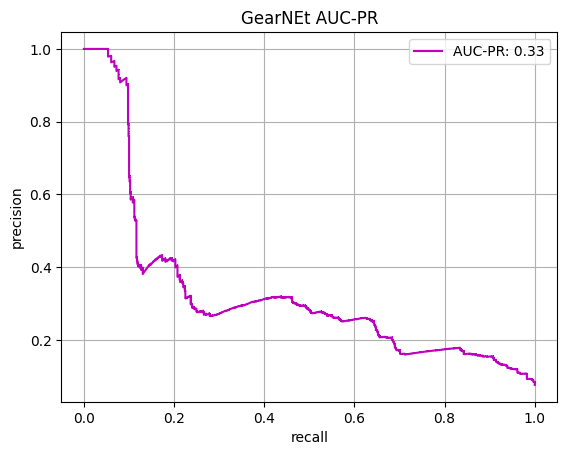

AucROC and aucpr Over all complexes 
 0.82 
 0.33 
total P:N ration 1: 12


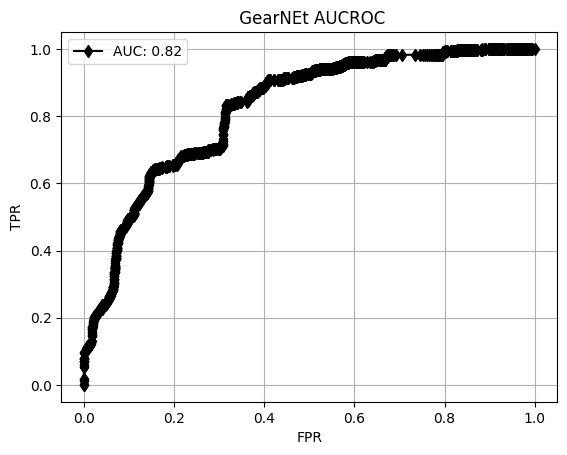

'\nprint("Final average over all folds,Leave one complex out",np.average(AUC_ROC_final).round(4),\'±\',np.std( AUC_ROC_final).round(4),np.average(Avg_P_final).round(4),\'±\',np.std( Avg_P_final).round(4))\nprint("averge score of test",np.average(Tscores_list))\nnp.save(path+\'All_loss.npy\',All_loss)\nnp.save (path+ \'AUC_list.npy\',AUC_list)\nnp.save (path+ \'PR_list.npy\',PR_list)\nfig=plt.figure()\nplt.plot(All_loss,color=\'k\',marker=\',\',label=\'Loss\')\nplt.grid()\nplt.legend()\nfig .savefig(path+"PPI Inhibitors loss over all complexes 30 epochs.pdf", bbox_inches=\'tight\')\n############\nfig=plt.figure()\nplt.plot(All_loss,color=\'k\',marker=\',\',label=\'Loss\')\nplt.plot( AUC_list,color=\'b\',marker=\',\',label=\'AUC\')\nplt.plot( PR_list,color=\'m\',marker=\',\',label=\'PR\')\nplt.grid()\nplt.legend()\nfig .savefig(path+"PPI Inhibitors loss-PR over all complexes.pdf", bbox_inches=\'tight\')\n'

In [ ]:
from sklearn.metrics import roc_auc_score,roc_curve,precision_score,recall_score,average_precision_score
import pickle
#Clone github reository to colab and give githubpath as /content/PPI-Inhibitors/
#path is the drive path  with foldername GNN-PPI-Inhibitor
path,githubpath='/content/drive/MyDrive/GNN-PPI-Inhibitor/','/content/PPI-Inhibitors/'
#####Gearnet DBD5
DBD5Gearnetpath=githubpath+'Features/GearNet Features DBD5/'#content/drive/MyDrive/GNN-PPI-Inhibitor/GearNet Features DBD5/'
contents = os.listdir(DBD5Gearnetpath)
#print(contents)
DBD5_Gearnet_dict={}
for k in contents:
  if len(k.split('.pdb'))>1:
    pdbcomp=torch.load(DBD5Gearnetpath+k)
    #name=k.split('_')[0]
    DBD5_Gearnet_dict[k.split('_')[0]]=torch.load(DBD5Gearnetpath+k)#torch.squeeze(pdbcomp.data)
Pos_Gearnet_dict=pickle.load(open(githubpath+'Features/Gearnet_2p2i_Embeddings.pkl','rb'))
#DBD5_Gearnet_dict=pickle.load(open(githubpath+'Features/Gearnet_DBD5_Embeddings.pkl','rb'))#
Complex_AllFeatures_dict=dict( list (Pos_Gearnet_dict.items())+list (DBD5_Gearnet_dict.items()))
##############
ComplexInterfaceFeatures={}
for key in Complex_AllFeatures_dict:
  if len(key.split('.'))>1:
    compname=key.split('.')[0]
    ComplexInterfaceFeatures[compname]=Complex_AllFeatures_dict[key].data#torch.squeeze(
  else:
    ComplexInterfaceFeatures[key]=Complex_AllFeatures_dict[key].data
#################################
CompoundFingerprintFeaturesDict=pickle.load(open(githubpath+'Features/Compound_Fingerprint_Features_Dict.npy',"rb"))
#Load Protein data for GNN
ProteinDataGNN_dict=pickle.load(open(path+'ProteinData_dict.pickle',"rb"))
DBD5_ProteinDataGNN_dict=pickle.load(open(path+'DBD5_ProteinData_dict.pickle',"rb"))
All_ProteinData_dict=dict( list (ProteinDataGNN_dict.items())+list (DBD5_ProteinDataGNN_dict.items()))
for d in All_ProteinData_dict:
  data=All_ProteinData_dict[d]
  All_ProteinData_dict[d]=[data[0].cuda(),data[1].cuda(),data[2].cuda(),data[3].cuda()]
#########
from tqdm import tqdm as tqdm
import pickle
from sklearn.model_selection import GroupKFold
from sklearn.preprocessing import StandardScaler
from sklearn.preprocessing import normalize
import pandas as pd
import random
from sklearn.metrics import auc,precision_recall_curve
###########
#with open(githubpath+'Data/WriteAllexamplesRandomBindersIdsAll_24JAN_Binary.txt') as f:
with open(githubpath+'Data/WriteAllexamplesRandomBindersIdsAll_24JAN.txt') as f:
    D = f.readlines()
Labels=[];Ligandnames=[];Complexs=[];TestPoscomplexes=[];#SMILESlist=[];
for d in tqdm(D):
  if len(d.split())==4:
      TestPoscomp,Complexname,Ligandname,label = d.split()
  else:
      TestPoscomp,Complexname,Ligandname,label = d.split()[0],d.split()[1],(' ').join(d.split()[2:-1]),d.split()[-1]
      #print ("Complexname",Complexname)
  TestPoscomplexes.append(TestPoscomp),Ligandnames.append(Ligandname);Complexs.append(Complexname);Labels.append(float (label))
###########Make dictionary, Rootcomplexname=(complexname,compoundname),label
Allexamples=dict (zip(zip(TestPoscomplexes,zip(Complexs,Ligandnames)),Labels))
#Group kfold
Alldata=list (Allexamples.keys())
KK=[k[0].split('_')[0] for k in Alldata]
groups = pd.DataFrame(KK)
gkf = GroupKFold(n_splits=len(set (KK)))
###########
import pdb
from torchmetrics.classification import BinaryHingeLoss
AUC_ROC_final=[];Avg_P_final=[];Z=[];Yo=[];Y_t=[];Y_score=[];
from os import listdir
AlltestExamples=[];Externallabels=[];ExternalscoresLOCO=[];covid19_Externallabels=[];covid19_ExternalscoresLOCO=[];Y_score=[];Y_t=[];classratio_dict={};
AUC_ROC_final=[];Avg_P_final=[];
Complexs,Ligandnames, Labels=np.array(Complexs),np.array(Ligandnames),np.array(Labels)
AlltestExamples=[];Externallabels=[];ExternalscoresLOCO=[];covid19_Externallabels=[];covid19_ExternalscoresLOCO=[];Y_score=[];Y_t=[];classratio_dict={};
AUC_ROC_final=[];Avg_P_final=[];
Complexs,Ligandnames, Labels=np.array(Complexs),np.array(Ligandnames),np.array(Labels)
TrainModel_dict={'3DAB':'95','3WN7':'95','1BKD':'65','2FLU':'170','1YCQ':'75','3TDU':'140','1F47':'140','2E3K':'90','4AJY':'66','3D9T':'55','2RNY':'70','1YCR':'40','1BXL':'110','2B4J':'170','2XA0':'155','1Z92':'90','1NW9':'99','4GQ6':'30','3UVW':'65','4QC3':'140','4YY6':'220','4ESG':'35 (1)'}
for trainindex, testindex in gkf.split(KK, KK, groups=groups):
    Alldata=np.array(Alldata)
    train,test=Alldata[trainindex],Alldata[testindex]
    Ctr=[];Ptr=[];y_train=[];Ctrname=[];Ptrname=[];Xtr=[];G=[];Cttname=[];Ctt=[];y_test=[];Ptt=[];Pttname=[];
    #Split train and test
    for t in train:
      GNNcomp=t[1][0].split('_')[0]
      if GNNcomp in ComplexInterfaceFeatures:
        Ctrname.append(t[1][1]);Ctr.append(CompoundFingerprintFeaturesDict[t[1][1]]);
        GearNetF=ComplexInterfaceFeatures[GNNcomp]#[0:69]
        Ptrname.append(GNNcomp);#Ptr.append(GearNetF.numpy());
        Ptr.append (GearNetF[0].numpy())
        y_train.append(Allexamples[t[0],t[1]])
    #Split train and test
    for t in test:
      GNNcomp=t[1][0].split('_')[0]
      if GNNcomp in ComplexInterfaceFeatures:
        Cttname.append(t[1][1]);Ctt.append(CompoundFingerprintFeaturesDict[t[1][1]]);
        #SeqonlyF=ComplexInterfaceFeatures[GNNcomp][0:69]
        GearNetF=ComplexInterfaceFeatures[GNNcomp]
        Pttname.append(GNNcomp);Ptt.append(GearNetF[0].numpy());#ComplexInterfaceFeatures[GNNcomp]);
        y_test.append(Allexamples[t[0],t[1]])
    #standarization of torch
    Pscaler = StandardScaler().fit(Ptr)
    Cscaler = StandardScaler().fit(Ctr)
    Ctr = Cscaler.transform(Ctr)
    Ptr=Pscaler.transform(Ptr)
    Ptt=Pscaler.transform(Ptt)
    Ptrdict=dict (zip(Ptrname,torch.FloatTensor(Ptr).cuda()))
    Ctrdict=dict (zip (Ctrname,torch.FloatTensor( Ctr).cuda()))
    Ctt = Cscaler.transform(Ctt)
    Cttdict=dict (zip (Cttname,torch.FloatTensor( Ctt).cuda()))
    Pttdict=dict (zip(Pttname,torch.FloatTensor(Ptt).cuda()))
    IPPI_Net = IPPI_MLP_Net().cuda()
    #############
    GNN_model=GNN().cuda()
    ############
    LOCOcomplexname=test[0][0].split('_')[0]
    if LOCOcomplexname in TrainModel_dict:
      Mepoch=TrainModel_dict[LOCOcomplexname]
      IPPI_Net.load_state_dict(torch.load(githubpath+'/GearNet and GNN Trained models/GearNt_IPPI_Net_'+ LOCOcomplexname+'_Epoch'+str (Mepoch)))
      GNN_model.load_state_dict(torch.load(githubpath+'/GearNet and GNN Trained models/GearNt_GNN_model_'+ LOCOcomplexname+'_Epoch'+str (Mepoch)))
      #############
      y_train=torch.FloatTensor( y_train).cuda()
      #Testing
      Y_score,Y_t=[],[]
      for nt in test:
        complexname,Ligandname =nt[1]
        GNNcomplex=complexname.split('_')[0]
        y_test=Allexamples[nt[0],nt[1]]
        if GNNcomplex in ComplexInterfaceFeatures:
          test_score=IPPI_Net(All_ProteinData_dict[GNNcomplex],Cttdict[Ligandname],Pttdict[GNNcomplex],GNN_model)
          Y_score.extend(test_score.cpu().data.numpy())
          Y_t.append(y_test)
      TestComplex=test[0][0]
      Z=np.append(Z,Y_score);Yo=np.append(Yo,Y_t);
      Auc=roc_auc_score(np.array(Y_t), np.array(Y_score))
      average_P_score=average_precision_score(Y_t,Y_score)
      Y_t=np.array(Y_t)
      #print("len of Z,Yo",len(Z),len(Yo),"Test P",complexname,"Final AUC",Auc,"Final PR",average_P_score)
      print(LOCOcomplexname,"\t",round (Auc,3),"\t",round (average_P_score,3) ,"\t",np.sum(Y_t[Y_t==1.0]),"\t",np.abs(np.sum(Y_t[Y_t==-1.0])),"\t",round (np.abs(np.sum(Y_t[Y_t==-1.0]))/np.sum(Y_t[Y_t==1.0]),1),"\n")#round (len(testNeg )/len(testPos),1))
      AUC_ROC_final.append(Auc);Avg_P_final.append(average_P_score);
fpr, tpr, thresholds = roc_curve(Yo, Z)#(Y_t, Y_score)
Auc = roc_auc_score(Yo, Z)
Auc=(Auc).round(2)
# calculate precision-recall curve
Z=np.array(Z);Yo=np.array(Yo);
Z_GearNet=np.array(Z);Yo_GearNet=np.array(Yo);
np.save(path+'Z_GearNet.npy',Z_GearNet)
np.save(path+'Yo_GearNet.npy',Yo_GearNet)
#Y_t=np.array(Y_t);Y_score=np.array(Y_score)
precision, recall, thresholds = precision_recall_curve(Yo, Z)
aucpr=average_precision_score (Yo, Z)
######
fig = plt.figure()
plt.plot(recall,precision,color='m',marker=',',label='AUC-PR:{: .2f}'.format(aucpr))
plt.title('GearNEt AUC-PR');plt.xlabel('recall');plt.ylabel('precision');plt.grid();plt.legend();plt.show();
fig .savefig(path+"GearNEt AUC-PR PPI Inhibitors MLP.pdf", bbox_inches='tight')
###
aucpr=(aucpr).round(2)
print("AucROC and aucpr Over all complexes \n",Auc,"\n",aucpr,"\ntotal P:N ration 1:",int (np.sum([Yo==-1.0])/np.sum([Yo==1.0])))#,"\n")
#######
fig = plt.figure()
plt.plot(fpr,tpr,color='k',marker='d',label='AUC:{: .2f}'.format(Auc))
plt.title(' GearNEt AUCROC');plt.xlabel('FPR');plt.ylabel('TPR');plt.grid();plt.legend();plt.show();
fig .savefig(path+"GearNEt AUCROC PPI Inhibitors MLP.pdf", bbox_inches='tight')